In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
import seaborn as sns
from xgboost import XGBClassifier, plot_importance
%matplotlib inline

In [2]:
feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+',
                                 header=None, names=['column_index', 'column_name'])
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출 : ', feature_name[:10])

전체 피처명에서 10개만 추출 :  ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [3]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [4]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                 columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name',
                                                             'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                              if x[1] >0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [5]:
def get_human_dataset():
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+',
                                 header=None, names=['column_index', 'column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    x_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    x_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_human_dataset()



In [6]:
print('## 학습 피처 데이터셋 info()')
print(x_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [7]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [9]:
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(x_train, y_train)
pred = dt_clf.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도 : {0:.4f}'.format(accuracy))

print('DecisionTreeClassifier 기본 하이퍼 파라미터 : \n', dt_clf.get_params())

결정 트리 예측 정확도 : 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터 : 
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 156, 'splitter': 'best'}


In [8]:
from sklearn.model_selection import GridSearchCV

In [11]:
params = {
    'max_depth' : [6,8,10,12,16,20,24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(x_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치 : {0:.4f}'. format(grid_cv.best_score_))
print('GridSearchCV 최적 하이처 파라미터 : ', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.2min finished


GridSearchCV 최고 평균 정확도 수치 : 0.8513
GridSearchCV 최적 하이처 파라미터 :  {'max_depth': 16}


In [12]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [13]:
max_depths = [6,8,10,12,16,20,24]

for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(x_train, y_train)
    pred = dt_clf.predict(x_test)
    accuracy = accuracy_score(y_test,pred)
    print('max_depth = {0} 정확도 : {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도 : 0.8558
max_depth = 8 정확도 : 0.8707
max_depth = 10 정확도 : 0.8673
max_depth = 12 정확도 : 0.8646
max_depth = 16 정확도 : 0.8575
max_depth = 20 정확도 : 0.8548
max_depth = 24 정확도 : 0.8548


In [14]:
params = {
    'max_depth' : [8,12,16,20],
    'min_samples_split' : [16,24],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(x_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치 : {0:4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터 :', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.5min finished


GridSearchCV 최고 평균 정확도 수치 : 0.854879
GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 8, 'min_samples_split': 16}


In [15]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(x_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도 : {0:.4f}'.format(accuracy))

결정 트리 예측 정확도 : 0.8717


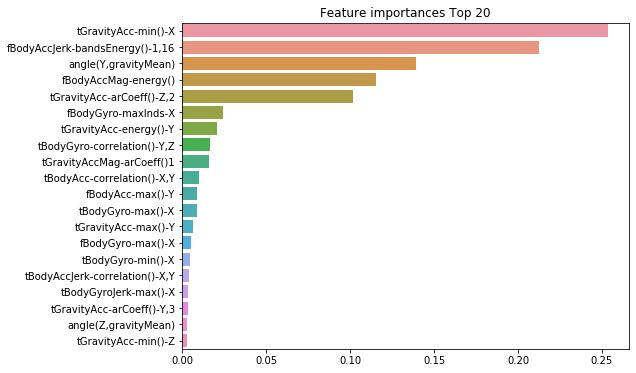

In [16]:
ftr_importances_values = best_df_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [16]:
cust_df = pd.read_csv('./train.csv', encoding='latin-1')
print('daraset shape:', cust_df.shape)
cust_df.head()

daraset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [17]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [18]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df.TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 1.00


In [19]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [20]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

x_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape : {0}'.format(x_features.shape))

피처 데이터 shape : (76020, 369)


In [21]:
from sklearn.model_selection import train_test_split

In [22]:

x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.2, shuffle=True, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 shape : {0}, 테스트 세트 shape : {1}'.format(x_train.shape, x_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 shape : (60816, 369), 테스트 세트 shape : (15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [28]:
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)
xgb_clf.fit(x_train, y_train,early_stopping_rounds=100,
           eval_metric='auc', eval_set=[(x_train, y_train), (x_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(x_test)[:,1], average='macro')
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

[142]	validation_0-auc:0.861553	validation_1-auc:0.841335
[143]	validation_0-auc:0.861682	validation_1-auc:0.841346
[144]	validation_0-auc:0.86169	validation_1-auc:0.841403
[145]	validation_0-auc:0.861852	validation_1-auc:0.841299
[146]	validation_0-auc:0.861898	validation_1-auc:0.841301
[147]	validation_0-auc:0.861998	validation_1-auc:0.841289
[148]	validation_0-auc:0.862068	validation_1-auc:0.84135
[149]	validation_0-auc:0.862132	validation_1-auc:0.841444
[150]	validation_0-auc:0.862236	validation_1-auc:0.841409
[151]	validation_0-auc:0.862314	validation_1-auc:0.841459
[152]	validation_0-auc:0.862584	validation_1-auc:0.841456
[153]	validation_0-auc:0.862843	validation_1-auc:0.841483
[154]	validation_0-auc:0.863033	validation_1-auc:0.841493
[155]	validation_0-auc:0.863132	validation_1-auc:0.841534
[156]	validation_0-auc:0.863423	validation_1-auc:0.841728
[157]	validation_0-auc:0.863578	validation_1-auc:0.841712
[158]	validation_0-auc:0.863872	validation_1-auc:0.841677
[159]	validation

In [11]:
from sklearn.model_selection import GridSearchCV

In [27]:
xgb_clf = XGBClassifier(n_estimators=100)
params = {'max_depth' : [5,7], 'min_child_weight' : [1,3], 'colsample_bytree' : [0.5,0.75]}

gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(x_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train, y_train), (x_test, y_test)])

print('GridSearchCV 최적 파라미터 :', gridcv.best_params_)
xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(x_test)[:,1], average='macro')
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.715421	validation_1-auc:0.722463
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.802772	validation_1-auc:0.807648
[2]	validation_0-auc:0.800147	validation_1-auc:0.804566
[3]	validation_0-auc:0.805692	validation_1-auc:0.809325
[4]	validation_0-auc:0.814807	validation_1-auc:0.816951
[5]	validation_0-auc:0.810346	validation_1-auc:0.812634
[6]	validation_0-auc:0.810623	validation_1-auc:0.814491
[7]	validation_0-auc:0.818556	validation_1-auc:0.820561
[8]	validation_0-auc:0.822006	validation_1-auc:0.823553
[9]	validation_0-auc:0.820433	validation_1-auc:0.821292
[10]	validation_0-auc:0.826212	validation_1-auc:0.825279
[11]	validation_0-auc:0.830077	validation_1-auc:0.827817
[12]	validation_0-auc:0.832328	validation_1-auc:0.828775
[13]	validation_0-auc:0.832008	validation_1-auc:0.827865
[14]	validation_0-auc:0.830319	validation_1-auc:0.82674

[51]	validation_0-auc:0.86387	validation_1-auc:0.843007
[52]	validation_0-auc:0.864428	validation_1-auc:0.843608
[53]	validation_0-auc:0.86492	validation_1-auc:0.843887
[54]	validation_0-auc:0.865341	validation_1-auc:0.844128
[55]	validation_0-auc:0.865713	validation_1-auc:0.843955
[56]	validation_0-auc:0.866165	validation_1-auc:0.844301
[57]	validation_0-auc:0.866538	validation_1-auc:0.84439
[58]	validation_0-auc:0.86671	validation_1-auc:0.844055
[59]	validation_0-auc:0.866977	validation_1-auc:0.843974
[60]	validation_0-auc:0.867483	validation_1-auc:0.8439
[61]	validation_0-auc:0.867853	validation_1-auc:0.843561
[62]	validation_0-auc:0.86811	validation_1-auc:0.843594
[63]	validation_0-auc:0.868319	validation_1-auc:0.843498
[64]	validation_0-auc:0.868554	validation_1-auc:0.843615
[65]	validation_0-auc:0.869021	validation_1-auc:0.843756
[66]	validation_0-auc:0.869095	validation_1-auc:0.843781
[67]	validation_0-auc:0.869277	validation_1-auc:0.843635
[68]	validation_0-auc:0.869639	validat

[1]	validation_0-auc:0.804027	validation_1-auc:0.809028
[2]	validation_0-auc:0.796929	validation_1-auc:0.805684
[3]	validation_0-auc:0.80379	validation_1-auc:0.811591
[4]	validation_0-auc:0.811904	validation_1-auc:0.818375
[5]	validation_0-auc:0.808826	validation_1-auc:0.815714
[6]	validation_0-auc:0.809236	validation_1-auc:0.816054
[7]	validation_0-auc:0.818354	validation_1-auc:0.823376
[8]	validation_0-auc:0.822085	validation_1-auc:0.826164
[9]	validation_0-auc:0.82165	validation_1-auc:0.824633
[10]	validation_0-auc:0.825876	validation_1-auc:0.828152
[11]	validation_0-auc:0.830307	validation_1-auc:0.830536
[12]	validation_0-auc:0.832494	validation_1-auc:0.831414
[13]	validation_0-auc:0.832283	validation_1-auc:0.831058
[14]	validation_0-auc:0.830152	validation_1-auc:0.829388
[15]	validation_0-auc:0.833723	validation_1-auc:0.831545
[16]	validation_0-auc:0.835902	validation_1-auc:0.833087
[17]	validation_0-auc:0.838024	validation_1-auc:0.835309
[18]	validation_0-auc:0.840344	validation_

[57]	validation_0-auc:0.863066	validation_1-auc:0.845717
[58]	validation_0-auc:0.863413	validation_1-auc:0.845678
[59]	validation_0-auc:0.863608	validation_1-auc:0.84581
[60]	validation_0-auc:0.86412	validation_1-auc:0.845891
[61]	validation_0-auc:0.864399	validation_1-auc:0.845775
[62]	validation_0-auc:0.864521	validation_1-auc:0.845851
[63]	validation_0-auc:0.864786	validation_1-auc:0.845721
[64]	validation_0-auc:0.865062	validation_1-auc:0.845821
[65]	validation_0-auc:0.865567	validation_1-auc:0.845831
[66]	validation_0-auc:0.865616	validation_1-auc:0.845926
[67]	validation_0-auc:0.865942	validation_1-auc:0.845591
[68]	validation_0-auc:0.866071	validation_1-auc:0.845562
[69]	validation_0-auc:0.866158	validation_1-auc:0.845375
[70]	validation_0-auc:0.866421	validation_1-auc:0.845291
[71]	validation_0-auc:0.866631	validation_1-auc:0.845063
[72]	validation_0-auc:0.866834	validation_1-auc:0.844927
[73]	validation_0-auc:0.867035	validation_1-auc:0.844978
[74]	validation_0-auc:0.867128	va

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.809965	validation_1-auc:0.808886
[2]	validation_0-auc:0.804423	validation_1-auc:0.807373
[3]	validation_0-auc:0.815189	validation_1-auc:0.816603
[4]	validation_0-auc:0.824234	validation_1-auc:0.823278
[5]	validation_0-auc:0.819568	validation_1-auc:0.81934
[6]	validation_0-auc:0.819199	validation_1-auc:0.818772
[7]	validation_0-auc:0.827364	validation_1-auc:0.826183
[8]	validation_0-auc:0.831947	validation_1-auc:0.829293
[9]	validation_0-auc:0.832248	validation_1-auc:0.827116
[10]	validation_0-auc:0.836511	validation_1-auc:0.829685
[11]	validation_0-auc:0.841032	validation_1-auc:0.831312
[12]	validation_0-auc:0.843673	validation_1-auc:0.831989
[13]	validation_0-auc:0.843697	validation_1-auc:0.832132
[14]	validation_0-auc:0.843356	validation_1-auc:0.830392
[15]	validation_0-auc:0.846759	validation_1-auc:0.83237

[77]	validation_0-auc:0.892957	validation_1-auc:0.844356
[78]	validation_0-auc:0.893228	validation_1-auc:0.84433
[79]	validation_0-auc:0.893375	validation_1-auc:0.844108
[80]	validation_0-auc:0.893476	validation_1-auc:0.844037
[81]	validation_0-auc:0.893656	validation_1-auc:0.844067
[82]	validation_0-auc:0.893838	validation_1-auc:0.843845
[83]	validation_0-auc:0.894993	validation_1-auc:0.84388
[84]	validation_0-auc:0.895174	validation_1-auc:0.843781
[85]	validation_0-auc:0.895171	validation_1-auc:0.844018
[86]	validation_0-auc:0.895293	validation_1-auc:0.843721
[87]	validation_0-auc:0.895377	validation_1-auc:0.843689
[88]	validation_0-auc:0.895614	validation_1-auc:0.8435
[89]	validation_0-auc:0.895597	validation_1-auc:0.84341
[90]	validation_0-auc:0.896023	validation_1-auc:0.843738
[91]	validation_0-auc:0.896194	validation_1-auc:0.843675
[92]	validation_0-auc:0.896304	validation_1-auc:0.843666
[93]	validation_0-auc:0.896388	validation_1-auc:0.8436
[94]	validation_0-auc:0.89645	validati

[17]	validation_0-auc:0.85058	validation_1-auc:0.835537
[18]	validation_0-auc:0.852488	validation_1-auc:0.836913
[19]	validation_0-auc:0.851413	validation_1-auc:0.83678
[20]	validation_0-auc:0.853824	validation_1-auc:0.837786
[21]	validation_0-auc:0.853711	validation_1-auc:0.836986
[22]	validation_0-auc:0.852989	validation_1-auc:0.835059
[23]	validation_0-auc:0.855112	validation_1-auc:0.836803
[24]	validation_0-auc:0.856859	validation_1-auc:0.838802
[25]	validation_0-auc:0.85723	validation_1-auc:0.83782
[26]	validation_0-auc:0.857535	validation_1-auc:0.836375
[27]	validation_0-auc:0.85929	validation_1-auc:0.837784
[28]	validation_0-auc:0.860972	validation_1-auc:0.837979
[29]	validation_0-auc:0.860682	validation_1-auc:0.837827
[30]	validation_0-auc:0.862143	validation_1-auc:0.838806
[31]	validation_0-auc:0.863184	validation_1-auc:0.839024
[32]	validation_0-auc:0.863638	validation_1-auc:0.838132
[33]	validation_0-auc:0.864268	validation_1-auc:0.838288
[34]	validation_0-auc:0.8644	validat

Stopping. Best iteration:
[65]	validation_0-auc:0.882333	validation_1-auc:0.843298

[0]	validation_0-auc:0.740963	validation_1-auc:0.745305
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.82294	validation_1-auc:0.821542
[2]	validation_0-auc:0.813813	validation_1-auc:0.809933
[3]	validation_0-auc:0.827473	validation_1-auc:0.822227
[4]	validation_0-auc:0.832393	validation_1-auc:0.826685
[5]	validation_0-auc:0.831888	validation_1-auc:0.822684
[6]	validation_0-auc:0.831945	validation_1-auc:0.821011
[7]	validation_0-auc:0.835043	validation_1-auc:0.824823
[8]	validation_0-auc:0.839917	validation_1-auc:0.82833
[9]	validation_0-auc:0.839675	validation_1-auc:0.827635
[10]	validation_0-auc:0.843606	validation_1-auc:0.829718
[11]	validation_0-auc:0.846078	validation_1-auc:0.833888
[12]	validation_0-auc:0.848075	validation_1-auc:0.834836
[13]	validation_0-auc:0.849433

[45]	validation_0-auc:0.860625	validation_1-auc:0.839082
[46]	validation_0-auc:0.860953	validation_1-auc:0.839125
[47]	validation_0-auc:0.861608	validation_1-auc:0.838995
[48]	validation_0-auc:0.862085	validation_1-auc:0.839059
[49]	validation_0-auc:0.862354	validation_1-auc:0.839387
[50]	validation_0-auc:0.862812	validation_1-auc:0.839298
[51]	validation_0-auc:0.863372	validation_1-auc:0.839127
[52]	validation_0-auc:0.864029	validation_1-auc:0.839097
[53]	validation_0-auc:0.864379	validation_1-auc:0.839118
[54]	validation_0-auc:0.864775	validation_1-auc:0.838848
[55]	validation_0-auc:0.86518	validation_1-auc:0.838897
[56]	validation_0-auc:0.865428	validation_1-auc:0.838671
[57]	validation_0-auc:0.865679	validation_1-auc:0.838451
[58]	validation_0-auc:0.866057	validation_1-auc:0.838382
[59]	validation_0-auc:0.866205	validation_1-auc:0.838363
[60]	validation_0-auc:0.866485	validation_1-auc:0.83804
[61]	validation_0-auc:0.866681	validation_1-auc:0.837604
[62]	validation_0-auc:0.867	valid

[17]	validation_0-auc:0.844972	validation_1-auc:0.836283
[18]	validation_0-auc:0.845411	validation_1-auc:0.836243
[19]	validation_0-auc:0.845623	validation_1-auc:0.837443
[20]	validation_0-auc:0.846563	validation_1-auc:0.837309
[21]	validation_0-auc:0.846794	validation_1-auc:0.837453
[22]	validation_0-auc:0.847843	validation_1-auc:0.837781
[23]	validation_0-auc:0.848615	validation_1-auc:0.838383
[24]	validation_0-auc:0.849434	validation_1-auc:0.838103
[25]	validation_0-auc:0.85036	validation_1-auc:0.838932
[26]	validation_0-auc:0.850801	validation_1-auc:0.838703
[27]	validation_0-auc:0.850936	validation_1-auc:0.837935
[28]	validation_0-auc:0.851557	validation_1-auc:0.837842
[29]	validation_0-auc:0.852139	validation_1-auc:0.837859
[30]	validation_0-auc:0.852693	validation_1-auc:0.8387
[31]	validation_0-auc:0.853579	validation_1-auc:0.838874
[32]	validation_0-auc:0.853998	validation_1-auc:0.838908
[33]	validation_0-auc:0.85455	validation_1-auc:0.839699
[34]	validation_0-auc:0.855415	vali

[59]	validation_0-auc:0.862575	validation_1-auc:0.839266
[60]	validation_0-auc:0.862755	validation_1-auc:0.839195
[61]	validation_0-auc:0.86307	validation_1-auc:0.839449
[62]	validation_0-auc:0.863241	validation_1-auc:0.839404
[63]	validation_0-auc:0.863658	validation_1-auc:0.839428
[64]	validation_0-auc:0.86375	validation_1-auc:0.839621
[65]	validation_0-auc:0.86421	validation_1-auc:0.839633
[66]	validation_0-auc:0.86447	validation_1-auc:0.839787
[67]	validation_0-auc:0.86483	validation_1-auc:0.839489
[68]	validation_0-auc:0.864976	validation_1-auc:0.839477
[69]	validation_0-auc:0.865145	validation_1-auc:0.83945
Stopping. Best iteration:
[39]	validation_0-auc:0.855169	validation_1-auc:0.840194

[0]	validation_0-auc:0.811089	validation_1-auc:0.810522
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.816087	validation_1-auc:0.810073
[2]	validation_0-auc:0.822

[27]	validation_0-auc:0.85049	validation_1-auc:0.838129
[28]	validation_0-auc:0.850674	validation_1-auc:0.837812
[29]	validation_0-auc:0.851227	validation_1-auc:0.838234
[30]	validation_0-auc:0.851623	validation_1-auc:0.838185
[31]	validation_0-auc:0.852504	validation_1-auc:0.838433
[32]	validation_0-auc:0.853015	validation_1-auc:0.838103
[33]	validation_0-auc:0.8536	validation_1-auc:0.838398
[34]	validation_0-auc:0.854335	validation_1-auc:0.838896
[35]	validation_0-auc:0.854663	validation_1-auc:0.839009
[36]	validation_0-auc:0.855138	validation_1-auc:0.839035
[37]	validation_0-auc:0.855351	validation_1-auc:0.839193
[38]	validation_0-auc:0.856105	validation_1-auc:0.839668
[39]	validation_0-auc:0.856527	validation_1-auc:0.83972
[40]	validation_0-auc:0.857019	validation_1-auc:0.840403
[41]	validation_0-auc:0.8577	validation_1-auc:0.840506
[42]	validation_0-auc:0.85823	validation_1-auc:0.840863
[43]	validation_0-auc:0.858341	validation_1-auc:0.840702
[44]	validation_0-auc:0.858849	validat

[4]	validation_0-auc:0.83547	validation_1-auc:0.826685
[5]	validation_0-auc:0.840865	validation_1-auc:0.832065
[6]	validation_0-auc:0.843256	validation_1-auc:0.831047
[7]	validation_0-auc:0.844488	validation_1-auc:0.82997
[8]	validation_0-auc:0.846035	validation_1-auc:0.83064
[9]	validation_0-auc:0.847946	validation_1-auc:0.831142
[10]	validation_0-auc:0.848745	validation_1-auc:0.831627
[11]	validation_0-auc:0.850347	validation_1-auc:0.832598
[12]	validation_0-auc:0.851272	validation_1-auc:0.832519
[13]	validation_0-auc:0.853669	validation_1-auc:0.834865
[14]	validation_0-auc:0.855251	validation_1-auc:0.835849
[15]	validation_0-auc:0.856435	validation_1-auc:0.83605
[16]	validation_0-auc:0.857587	validation_1-auc:0.836177
[17]	validation_0-auc:0.859351	validation_1-auc:0.836231
[18]	validation_0-auc:0.860285	validation_1-auc:0.836331
[19]	validation_0-auc:0.860357	validation_1-auc:0.837599
[20]	validation_0-auc:0.862392	validation_1-auc:0.83764
[21]	validation_0-auc:0.862808	validation_

[63]	validation_0-auc:0.89141	validation_1-auc:0.841085
[64]	validation_0-auc:0.891682	validation_1-auc:0.841143
[65]	validation_0-auc:0.892278	validation_1-auc:0.841065
[66]	validation_0-auc:0.892727	validation_1-auc:0.840958
[67]	validation_0-auc:0.893137	validation_1-auc:0.840921
[68]	validation_0-auc:0.893388	validation_1-auc:0.840771
[69]	validation_0-auc:0.893529	validation_1-auc:0.84087
[70]	validation_0-auc:0.893802	validation_1-auc:0.840709
[71]	validation_0-auc:0.893855	validation_1-auc:0.840794
[72]	validation_0-auc:0.894019	validation_1-auc:0.840836
[73]	validation_0-auc:0.894373	validation_1-auc:0.841008
[74]	validation_0-auc:0.894542	validation_1-auc:0.840932
[75]	validation_0-auc:0.894724	validation_1-auc:0.840937
Stopping. Best iteration:
[45]	validation_0-auc:0.884335	validation_1-auc:0.842062

[0]	validation_0-auc:0.816109	validation_1-auc:0.811
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-a

[59]	validation_0-auc:0.882357	validation_1-auc:0.841579
[60]	validation_0-auc:0.882716	validation_1-auc:0.841512
[61]	validation_0-auc:0.882939	validation_1-auc:0.841415
[62]	validation_0-auc:0.883049	validation_1-auc:0.841426
[63]	validation_0-auc:0.883365	validation_1-auc:0.841612
[64]	validation_0-auc:0.883681	validation_1-auc:0.841852
[65]	validation_0-auc:0.884057	validation_1-auc:0.841847
[66]	validation_0-auc:0.884053	validation_1-auc:0.841909
[67]	validation_0-auc:0.88446	validation_1-auc:0.841985
[68]	validation_0-auc:0.884938	validation_1-auc:0.841768
[69]	validation_0-auc:0.885009	validation_1-auc:0.841656
[70]	validation_0-auc:0.885288	validation_1-auc:0.841626
[71]	validation_0-auc:0.885498	validation_1-auc:0.841288
[72]	validation_0-auc:0.885587	validation_1-auc:0.841334
[73]	validation_0-auc:0.885921	validation_1-auc:0.841217
[74]	validation_0-auc:0.886022	validation_1-auc:0.841253
[75]	validation_0-auc:0.886104	validation_1-auc:0.841179
[76]	validation_0-auc:0.886118	v

[19]	validation_0-auc:0.846482	validation_1-auc:0.838554
[20]	validation_0-auc:0.848726	validation_1-auc:0.840214
[21]	validation_0-auc:0.847695	validation_1-auc:0.838583
[22]	validation_0-auc:0.84676	validation_1-auc:0.838167
[23]	validation_0-auc:0.848966	validation_1-auc:0.83963
[24]	validation_0-auc:0.850153	validation_1-auc:0.840161
[25]	validation_0-auc:0.850518	validation_1-auc:0.838865
[26]	validation_0-auc:0.850326	validation_1-auc:0.83861
[27]	validation_0-auc:0.851898	validation_1-auc:0.839714
[28]	validation_0-auc:0.853439	validation_1-auc:0.83974
[29]	validation_0-auc:0.853446	validation_1-auc:0.840649
[30]	validation_0-auc:0.854315	validation_1-auc:0.840818
[31]	validation_0-auc:0.855389	validation_1-auc:0.841412
[32]	validation_0-auc:0.855959	validation_1-auc:0.841502
[33]	validation_0-auc:0.856346	validation_1-auc:0.841478
[34]	validation_0-auc:0.856286	validation_1-auc:0.841234
[35]	validation_0-auc:0.857969	validation_1-auc:0.842276
[36]	validation_0-auc:0.859291	vali

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.2, shuffle=True, random_state=0)

xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)
xgb_clf.fit(x_train, y_train, early_stopping_rounds=200, eval_metric="auc", eval_set=[(x_train, y_train),(x_test, y_test)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(x_test)[:,1], average='macro')

print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82311	validation_1-auc:0.815226
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.827094	validation_1-auc:0.816566
[2]	validation_0-auc:0.832027	validation_1-auc:0.820393
[3]	validation_0-auc:0.835873	validation_1-auc:0.825019
[4]	validation_0-auc:0.838197	validation_1-auc:0.826078
[5]	validation_0-auc:0.837948	validation_1-auc:0.827282
[6]	validation_0-auc:0.8381	validation_1-auc:0.826888
[7]	validation_0-auc:0.838475	validation_1-auc:0.827131
[8]	validation_0-auc:0.839775	validation_1-auc:0.828198
[9]	validation_0-auc:0.83981	validation_1-auc:0.827834
[10]	validation_0-auc:0.841664	validation_1-auc:0.828996
[11]	validation_0-auc:0.841069	validation_1-auc:0.82802
[12]	validation_0-auc:0.841167	validation_1-auc:0.828517
[13]	validation_0-auc:0.841455	validation_1-auc:0.828317
[14]	validation_0-auc:0.845308	validation_1-auc:0.834099
[1

[142]	validation_0-auc:0.878656	validation_1-auc:0.843428
[143]	validation_0-auc:0.878713	validation_1-auc:0.843385
[144]	validation_0-auc:0.878905	validation_1-auc:0.843463
[145]	validation_0-auc:0.879131	validation_1-auc:0.843475
[146]	validation_0-auc:0.87937	validation_1-auc:0.843636
[147]	validation_0-auc:0.879459	validation_1-auc:0.843606
[148]	validation_0-auc:0.879425	validation_1-auc:0.843573
[149]	validation_0-auc:0.879568	validation_1-auc:0.843621
[150]	validation_0-auc:0.879684	validation_1-auc:0.843523
[151]	validation_0-auc:0.879746	validation_1-auc:0.843485
[152]	validation_0-auc:0.879772	validation_1-auc:0.84348
[153]	validation_0-auc:0.87969	validation_1-auc:0.843363
[154]	validation_0-auc:0.880169	validation_1-auc:0.843571
[155]	validation_0-auc:0.880258	validation_1-auc:0.84347
[156]	validation_0-auc:0.88067	validation_1-auc:0.84353
[157]	validation_0-auc:0.880969	validation_1-auc:0.843364
[158]	validation_0-auc:0.881349	validation_1-auc:0.843599
[159]	validation_0-a

[284]	validation_0-auc:0.903908	validation_1-auc:0.844534
[285]	validation_0-auc:0.903983	validation_1-auc:0.844493
[286]	validation_0-auc:0.904128	validation_1-auc:0.844469
[287]	validation_0-auc:0.904224	validation_1-auc:0.844478
[288]	validation_0-auc:0.904337	validation_1-auc:0.844413
[289]	validation_0-auc:0.904409	validation_1-auc:0.844408
[290]	validation_0-auc:0.904532	validation_1-auc:0.844505
[291]	validation_0-auc:0.904571	validation_1-auc:0.84446
[292]	validation_0-auc:0.904651	validation_1-auc:0.844474
[293]	validation_0-auc:0.904717	validation_1-auc:0.84443
[294]	validation_0-auc:0.904796	validation_1-auc:0.844373
[295]	validation_0-auc:0.9049	validation_1-auc:0.844322
[296]	validation_0-auc:0.904981	validation_1-auc:0.844269
[297]	validation_0-auc:0.9051	validation_1-auc:0.844265
[298]	validation_0-auc:0.905163	validation_1-auc:0.844253
[299]	validation_0-auc:0.905254	validation_1-auc:0.844185
[300]	validation_0-auc:0.905318	validation_1-auc:0.84414
[301]	validation_0-au

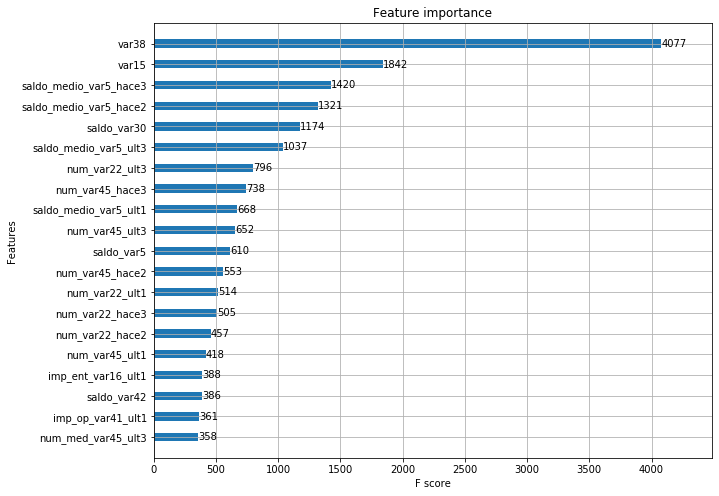

In [30]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)